In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import momlevel
from dask.diagnostics import ProgressBar

In [2]:
data_dir = '/work/jet/sea_level_covariability/data/zarr/'
fname = 'AVISO_global_1994to2020_zos_monthly'
ds = xr.open_zarr(f'{data_dir+fname}',use_cftime=True)

In [3]:
# mean annual cycle -- one value per calendar month
ds = ds.set_coords(['geolon', 'geolat'])
ann_cycle = momlevel.util.annual_cycle(ds.zos)

In [4]:
# amplitude of seasonal cycle
ann_cycle_amplitude = ann_cycle.max('time') - ann_cycle.min('time')
ann_cycle_amplitude = ann_cycle_amplitude.rename('zos_annual_amplitude')

/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


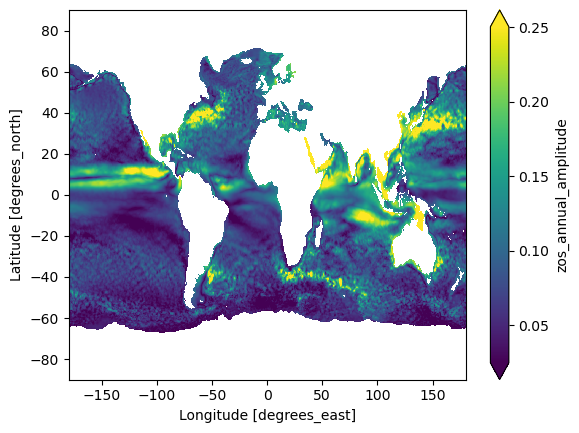

In [5]:
ann_cycle_amplitude.plot(robust=True)

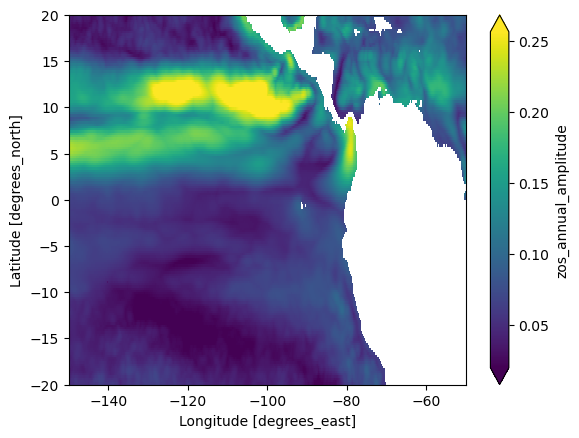

In [6]:
ann_cycle_amplitude.sel(xh=slice(-150,-50),yh=slice(-20,20)).plot(robust=True)

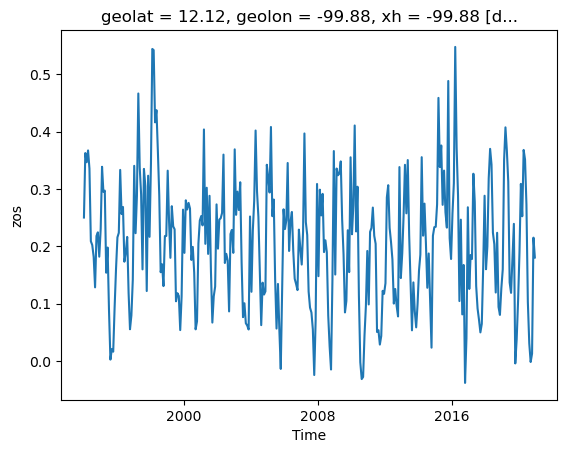

In [7]:
ds.sel({'xh':-100,'yh':12},method='nearest').zos.plot()

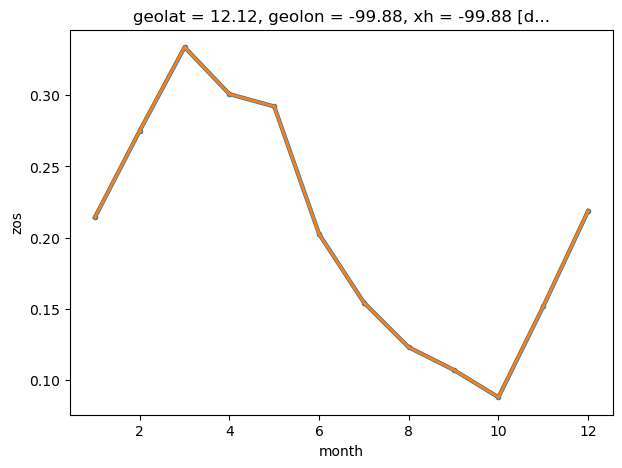

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
ds.zos.groupby('time.month').mean('time').sel({'xh':-100,'yh':12},method='nearest').plot(ax=ax,marker='o',ms=3, lw=3)
ax.plot(ann_cycle.time.dt.month,ann_cycle.sel({'xh':-100,'yh':12},method='nearest'),marker='+',ms=3, lw=2)
plt.show()

### Seasonal model
Function to calculate a seasonal cycle in a time series This function creates a modelled time series that includes a linear trend and annual and semi-annual harmonics
```
f(time) = b + m * time + c1 * sin(2*pi*time/year) + …
c2 * cos(2*pi*time/year) + c3 * sin(4*pi*time/year) + … c4 * cos(4*pi*time/year) + residual
```

In [10]:
zos_seasonal_model = momlevel.trend.seasonal_model(ds.zos)

/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/dask/array/einsumfuncs.py:234: PerformanceWarning: Increasing number of chunks by factor of 66
  result = blockwise(
/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 66
  result = blockwise(


In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ds.sel({'xh':-100,'yh':12},method='nearest').zos.plot(ax=ax,c='k')
zos_seasonal_model.sel({'xh':-100,'yh':12},method='nearest').plot(ax=ax)
plt.show()

### Calculate anomlies
At each grid point remove the temporal mean and/or seasonal cycle.

In [7]:
da = ds.zos-ds.zos.mean('time')
da_anm = da.groupby('time.month') - da.groupby('time.month').mean('time')

/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 27 times more chunks
  return self.array[key]


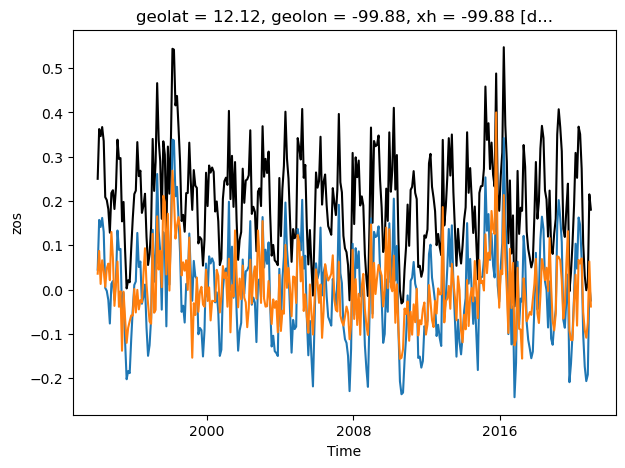

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
ds.sel({'xh':-100,'yh':12},method='nearest').zos.plot(ax=ax,c='k')
da.sel({'xh':-100,'yh':12},method='nearest').plot(ax=ax)
da_anm.sel({'xh':-100,'yh':12},method='nearest').plot(ax=ax)
plt.show()

### Trend

In [9]:
nmonths = xr.DataArray(da.time.dt.days_in_month,coords=[da.time],dims=['time'],name='weights')

In [11]:
da_ann = (da_anm * nmonths).groupby('time.year').sum('time') / nmonths.groupby('time.year').sum('time')

In [15]:
da_lfit = momlevel.trend.calc_linear_trend(da_ann.rename('zos'), dim='year')

In [19]:
with ProgressBar():
    da_trnd = da_lfit.zos_slope.load()

[########################################] | 100% Completed | 94.26 s


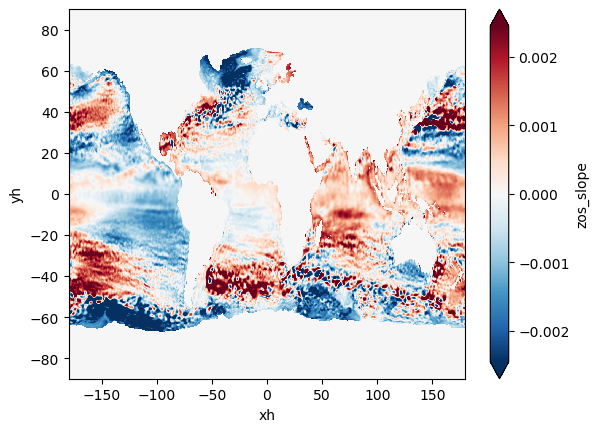

In [20]:
da_trnd.plot(robust=True,cmap='RdBu_r')

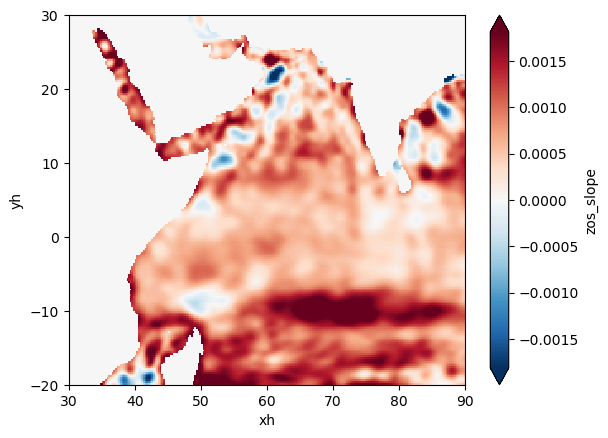

In [26]:
da_trnd.sel(xh=slice(30,90),yh=slice(-20,30)).plot(robust=True)

In [28]:
da_dtr = momlevel.trend.linear_detrend(da_anm)

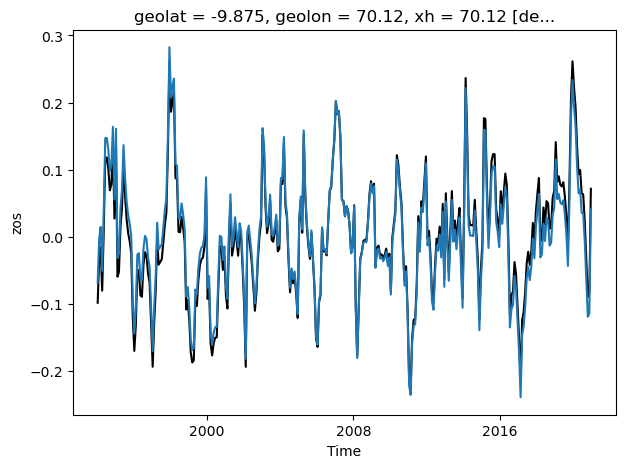

In [29]:
fig, ax = plt.subplots(figsize=(7,5))
da_anm.sel({'xh':70,'yh':-10},method='nearest').plot(ax=ax,c='k')
da_dtr.sel({'xh':70,'yh':-10},method='nearest').plot(ax=ax)
plt.show()

### Good locations
Find pixel locations where all the data is present for each time point. Ff even one time point at a given location is missing, that location will be excluded from the eof analysis

In [34]:
# Ensure the data is loaded as a Dask array
da_dtr = da_dtr.chunk({'time': 1})

In [37]:
# Sum of finite values along the 'time' dimension
flattend_array = xr.apply_ufunc(np.isfinite, da_dtr, dask='parallelized', output_dtypes=[bool]).sum(dim='time')

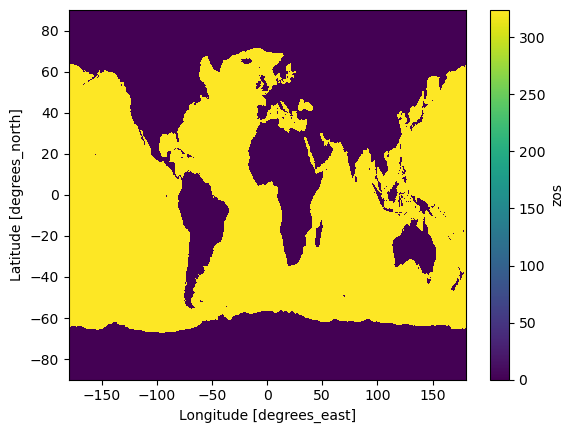

In [39]:
flattend_array.plot()

In [40]:
# Locations in the 2D array that have all good data for all time points
good_locations = flattend_array == len(da_dtr.time)

# Get indices of good locations
good_indices = np.where(good_locations.values)

### Create EOF matrix

In [41]:
# Create an empty array for the EOF matrix
n = len(da_dtr.time)
eof_matrix = np.zeros((n, len(good_indices[0])), dtype=float)

In [43]:
da_dtr.isel(time=i).values[good_indices]

array([0.00804834, 0.00420733, 0.00449781, ..., 0.00944847, 0.00791848,
       0.00615277])

In [ ]:
# Fill the EOF matrix
for i in range(n):
    print(i)
    with ProgressBar():
        result = da_dtr.isel(time=i).values[good_indices]
    eof_matrix[i, :] = result

0
[########################################] | 100% Completed | 80.48 s
1
[########################################] | 100% Completed | 81.61 s
2
[########################################] | 100% Completed | 81.79 s
3
[########################################] | 100% Completed | 79.46 s
4
[########################################] | 100% Completed | 81.07 s
5
[########################################] | 100% Completed | 80.48 ss
6
[########################################] | 100% Completed | 80.78 s
7
[########################################] | 100% Completed | 84.03 s
8
[########################################] | 100% Completed | 83.50 ss
9
[########################################] | 100% Completed | 83.92 s
10
[########################################] | 100% Completed | 82.47 s
11
[########################################] | 100% Completed | 90.95 s
12
[########################################] | 100% Completed | 85.44 ss
13
[########################################] | 100% Compl

In [ ]:
# Convert EOF matrix to a DataArray for better handling with xarray
eof_matrix_da = xr.DataArray(eof_matrix, dims=['time', 'location'], coords={'time': da_dtr.time})

In [ ]:
ds_out = eof_matrix_da.to_dataset(name='eof_matrix_da')
ds_out.to_netcdf('eof_matrix_da.nc', format='NETCDF4')

### Normalize each time series
Normalize the time series at each location by dividing by the standard deviation of the data at the respective location.

In [ ]:
stdv_geophys = np.asarray(map(np.sqrt, np.sum(eof_matrix**2.0,axis=0)))/(n-1)

for i in range(n):
    eof_matrix[i,:] = eof_matrix[i,:]/stdv_geophys

### Singular Value Decomposition
Note: Transpose is taken becaue svd function expects a matrix that has vectors that are trasnposed relative to how the data were orginally read into the `eof_matrix`.

In [ ]:
from scipy.linalg import svd

In [ ]:
eof_matrix = np.transpose(eof_matrix)

U, S, V = svd(eof_matrix,full_matrices=False)

### Calculate variances

In [ ]:
variances = 100.0*S**2/np.sum(S**2)

### Singular values

In [ ]:
s_matrix= np.zeros((n, n))

for i in range(n):
    s_matrix[i,i]=S[i]

### PC timeseries

In [ ]:
svdc_time_series = np.dot(s_matrix,V)

### Sort index
Sort eof/svd index order so that each eof mode variance explained goes from mode with the highest amount of orginal variance explained to mode with least amount of variance explained. This gives output with mode 1 having the highest explained variance.

In [ ]:
sorted_var_index = np.argsort(-variances)

In [ ]:
print '1993-2015:'
print 1, ':  ', variances[sorted_var_index[0]]
print 2, ':  ', variances[sorted_var_index[1]]
print 3, ':  ', variances[sorted_var_index[2]]

In [ ]:
### Set dimensions

In [ ]:
xdim=np.shape(arr)[2]
ydim=np.shape(arr)[1]

In [ ]:
### Spatial Eigenfunction

In [ ]:
arr_img = np.zeros((ydim,xdim)) + np.nan

### Map 1st mode

In [ ]:
arr_img[good_locations[0],good_locations[1]] = U[:,sorted_var_index[0]]

In [ ]:
# Use +/- (1.0) to change the color coding of weights
pc_normalize_factor = np.nanmax(abs(arr_img))*(-1.0)
eof01 = arr_img/pc_normalize_factor

In [ ]:
plt.figure(figsize=(11,5))

plt.title('Spatial Eigenfunction Mode 1 (1993-2015)',fontsize=16)
plt.imshow(np.flipud(eof01), cmap='RdBu_r', vmin=-1.0, vmax=1.0)
plt.colorbar(orientation='vertical')

#plt.savefig('/tmp/figure.png')
plt.show()